# Data Integration Tutorial

This tutorial is a companion to <ins>***IN-situ DEtailed Phenotyping To High-resolution transcriptomics (IN-DEPTH)***</ins> demonstrating the data integration workflow. The pipeline has two major components:

- Image preprocessing 
- Image registration using a shared marker as the bridge. (DAPI and SYTO13 in this case, which both capture the morphology of the cell nuclei) 

This tutorial aims to provide a basic template to convey the core concepts of the workflow. The users are welcome to change the specific tools for each part as pertained to their own data and specific needs. Here we demonstrate how to integrate CODEX with GeoMx. 


In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from skimage.segmentation import find_boundaries
from tqdm import tqdm

TQDM_FORMAT = "{desc}: {percentage:3.0f}%|{bar:30}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"

In [2]:
def uint16_to_uint8(image, quantile_min=0.1, quantile_max=99.9):
    """
    Convert a uint16 image to uint8 using specified quantiles for scaling.
    """
    if image.dtype == np.uint16:
        v_min, v_max = np.percentile(image, [quantile_min, quantile_max])
        image = (image - v_min) / (v_max - v_min) * 255
        image = np.clip(image, 0, 255)
        image = image.astype("uint8")
    return image


def ax_plot_core_positions(
    core_positions_df,
    x_min="x1",
    x_max="x2",
    y_min="y1",
    y_max="y2",
    core_id="core",
    step=1,
    text_size=10,
    text_color="red",
    rect_edgecolors="r",
    rect_linewidth=1,
    rect_facecolors="none",
    ax=None,
):
    """
    Plot core rectangles and text labels on ax.

    Parameters:
        core_positions_df: DataFrame with core positions
        x_min, x_max, y_min, y_max: column names for rectangle coordinates
        core_id: column name for core label
        step: downsampling factor
        text_size: font size for text
        text_color: color for text
        rect_edgecolors: edge color for rectangles
        rect_linewidth: line width for rectangles
        rect_facecolors: face color for rectangles
        ax: matplotlib axis
    """
    if ax is None:
        ax = plt.gca()

    patch_list = []
    for _, row in core_positions_df.iterrows():
        rect = Rectangle(
            (row[x_min] // step, row[y_min] // step),
            (row[x_max] - row[x_min]) // step,
            (row[y_max] - row[y_min]) // step,
        )
        patch_list.append(rect)

        ax.text(
            (row[x_min] + row[x_max]) // 2 // step,
            (row[y_min] + row[y_max]) // 2 // step,
            str(row[core_id]),
            color=text_color,
            ha="center",
            va="center",
            fontsize=text_size,
        )

    patch_collection = PatchCollection(
        patch_list,
        linewidths=rect_linewidth,
        edgecolors=rect_edgecolors,
        facecolors=rect_facecolors,
    )
    ax.add_collection(patch_collection)


def segmentation_mask_to_phenotype_map(
    segmentation_mask,
    annotation_df,
):
    """
    Convert segmentation mask to RGB image using annotation_df['color'].
    segmentation_mask: 2D numpy array of cell labels
    annotation_df: DataFrame with columns 'cell_label', 'annotation', 'color'
    Returns: RGB image (height, width, 3)
    """
    mask = np.isin(segmentation_mask, annotation_df["cell_label"].values)
    segmentation_mask = segmentation_mask.copy()
    segmentation_mask[~mask] = 0

    segmentation_mask_label = np.zeros_like(segmentation_mask)

    # cell boundary
    boundaries = find_boundaries(
        segmentation_mask, mode="inner", connectivity=1, background=0
    )

    labels = annotation_df[
        annotation_df["cell_label"].isin(np.unique(segmentation_mask))
    ]["annotation"].unique()
    label_ids = np.arange(1, len(labels) + 1).tolist()
    annotation_dict = dict(zip(labels, label_ids))

    color_dict = dict(zip(annotation_df["annotation"], annotation_df["color"]))

    height, width = segmentation_mask.shape
    if len(label_ids) == 0:
        return np.zeros((height, width, 3), dtype=np.uint8), color_dict
    else:
        color_mapping = np.zeros((np.max(label_ids) + 1, 3), dtype=np.uint8)

    for annotation in labels:
        color_code = color_dict[annotation]
        rgb_color = tuple(int(color_code[i : i + 2], 16) for i in (1, 3, 5))
        color_mapping[annotation_dict[annotation]] = rgb_color

        mask = np.isin(
            segmentation_mask,
            annotation_df[annotation_df["annotation"] == annotation]["cell_label"],
        )
        segmentation_mask_label[mask] = annotation_dict[annotation]

    colored_mask = color_mapping[segmentation_mask_label]

    colored_mask[segmentation_mask_label == 0] = (0, 0, 0)
    colored_mask[boundaries] = (255, 255, 255)

    return colored_mask, color_dict


def ax_plot_segmentation_mask(
    segmentation_mask, annotation_df, title=None, ax=None, legend=False
):
    """
    Plot a segmentation mask with legend using annotation_df['color'].
    """
    if ax is None:
        ax = plt.gca()

    img, color_dict = segmentation_mask_to_phenotype_map(
        segmentation_mask, annotation_df
    )

    ax.imshow(img)

    if title:
        ax.set_title(title)
    ax.axis("off")

    if legend:
        annotation_df = annotation_df[
            annotation_df["cell_label"].isin(np.unique(segmentation_mask))
        ]
        handles = [
            plt.Line2D(
                [0],
                [0],
                marker="s",
                color="black",
                label=label,
                markersize=10,
                markerfacecolor=color_dict[label],
                linestyle="None",
            )
            for label in color_dict.keys()
        ]
        ax.legend(
            handles=handles,
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
            fontsize=10,
        )


def ax_plot_legend(color_dcit, ax=None):
    if ax is None:
        ax = plt.gca()
    handles = [
        plt.Line2D(
            [0],
            [0],
            marker="s",
            color="black",
            label=label,
            markersize=10,
            markerfacecolor=color_dcit[label],
            linestyle="None",
        )
        for label in color_dcit.keys()
    ]
    ax.legend(
        handles=handles,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        fontsize=10,
    )

## 1. Image Preprocessing

In [3]:
input_dir = Path("/mnt/nfs/storage/wenruiwu_temp/indepth/tutorial/input")
output_dir = Path("/mnt/nfs/storage/wenruiwu_temp/indepth/tutorial/output")

### 1-1. GeoMx Data

#### 1-1-1. GeoMx SYTO13 image (slide)

In [ ]:
# Load GeoMx SYTO13 image
geomx_dapi_f = input_dir / "geomx_dapi.tiff"
geomx_dapi = tifffile.imread(geomx_dapi_f)
print(f"GeoMx SYTO13 loaded: shape = {geomx_dapi.shape}, dtype = {geomx_dapi.dtype}")

GeoMx DAPI loaded: shape = (49152, 49152), dtype = uint16


Image of uint16 is not supported for the SIFT alignment. So we need to convert the image of uint16 to uint8.

In [5]:
# geomx_dapi = uint16_to_uint8(geomx_dapi)
# print(f"GeoMx DAPI converted to {geomx_dapi.dtype}")
# tifffile.imwrite(input_dir / "geomx_dapi_uint8.tiff", geomx_dapi)

In [ ]:
geomx_dapi_uint8_f = input_dir / "geomx_dapi_uint8.tiff"
geomx_dapi = tifffile.imread(geomx_dapi_uint8_f)
print(f"GeoMx SYTO13 loaded: shape = {geomx_dapi.shape}, dtype = {geomx_dapi.dtype}")

GeoMx DAPI loaded: shape = (49152, 49152), dtype = uint8


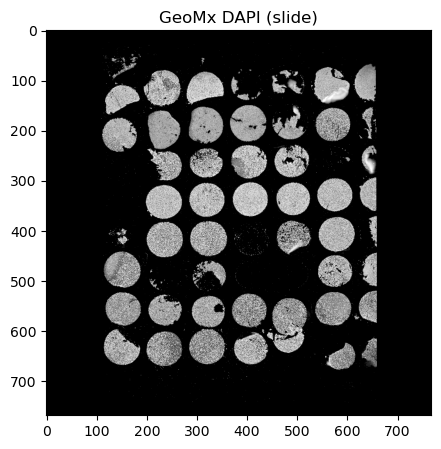

In [ ]:
# Visualize GeoMx DAPI image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(np.log1p(geomx_dapi[::64, ::64]), cmap="gray")
ax.set_title("GeoMx SYTO13 (slide)");

#### 1-1-2. GeoMx core position

In [8]:
# Load GeoMx core position
geomx_core_positions_f = Path(input_dir / "geomx_core_positions.csv")
geomx_core_positions = pd.read_csv(geomx_core_positions_f)
print(geomx_core_positions.head())

  core     x1     x2     y1     y2
0  1.1  39984  42365  38483  43136
1  1.2  34015  39984  38483  43600
2  2.1  28750  34015  39123  41520
3  2.2  23280  28750  38235  43032
4  3.1  17745  23280  38235  43032


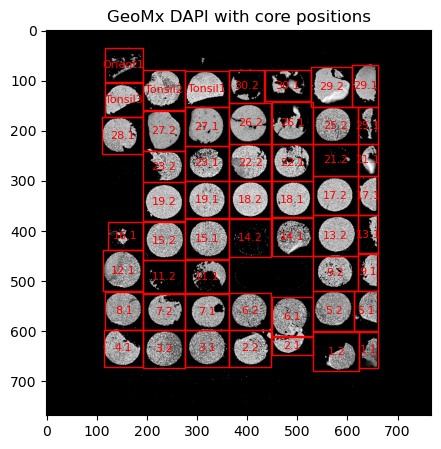

In [9]:
# Visualize core positions on images
step = 64
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(np.log1p(geomx_dapi[::step, ::step]), cmap="gray")
ax_plot_core_positions(geomx_core_positions, step=step, text_size=8)
ax.set_title("GeoMx DAPI with core positions");

#### 1-1-3. GeoMx ROI position

For the GeoMx platform, we can export the SYTO13 images of each ROI we selected and have the positions of each ROI relative to the whole slide. However, the unit of the positions is um. We need to convert it to pixel. 

In [10]:
# geomx_dapi_roi_f = input_dir / "geomx_dapi_roi.tiff"
# geomx_dapi_roi = tifffile.imread(geomx_dapi_roi_f)
# print(
#     f"GeoMx DAPI ROI loaded: shape = {geomx_dapi_roi.shape}, dtype = {geomx_dapi_roi.dtype}"
# )

In [11]:
# GeoMx ROI size in pixel
geomx_roi_width_px, geomx_roi_height_px = 1659, 1970

# GeoMx ROI size and position in um
geomx_roi_width_um, geomx_roi_height_um = 660, 785
roi_position_um = [
    ["1b", 15296.2, 16463.3],
    ["11a", 8536.1, 12135.1],
    ["12a", 4300.4, 11992],
    ["13b", 14962.4, 10338.6],
    ["14a", 13023.2, 10536.9],
    ["15b", 6221.7, 10962.5],
    ["17a", 16419, 7985.6],
    ["18b", 10138.5, 8467.4],
    ["19b", 6201.4, 8687.7],
    ["2b", 10330.6, 16493],
    ["21a", 16425.2, 5819.1],
    ["22b", 10217.9, 6252.2],
    ["23b", 6418.3, 6883.7],
    ["3b", 5629.8, 16416.3],
    ["4a", 3400, 15920.9],
    ["6a", 12041.9, 14326.6],
    ["7a", 7929.7, 14268.7],
    ["8a", 3496.3, 14047.4],
    ["9a", 16474.1, 12653.3],
    ["Tonsil1", 8429.2, 2839.2],
]
geomx_roi_positions = pd.DataFrame(
    roi_position_um, columns=["roi", "x_cent_um", "y_cent_um"]
)

# GeoMx microns per pixel
geomx_mpp_x = geomx_roi_width_um / geomx_roi_width_px
geomx_mpp_y = geomx_roi_height_um / geomx_roi_height_px

geomx_roi_positions["x_cent_px"] = geomx_roi_positions["x_cent_um"] / geomx_mpp_x
geomx_roi_positions["y_cent_px"] = geomx_roi_positions["y_cent_um"] / geomx_mpp_y

geomx_roi_positions["x_min_px"] = (
    geomx_roi_positions["x_cent_px"] - geomx_roi_width_px / 2
)
geomx_roi_positions["x_max_px"] = (
    geomx_roi_positions["x_cent_px"] + geomx_roi_width_px / 2
)

geomx_roi_positions["y_min_px"] = (
    geomx_roi_positions["y_cent_px"] - geomx_roi_height_px / 2
)
geomx_roi_positions["y_max_px"] = (
    geomx_roi_positions["y_cent_px"] + geomx_roi_height_px / 2
)

geomx_roi_positions[["x_min_px", "y_min_px", "x_max_px", "y_max_px"]] = (
    geomx_roi_positions[["x_min_px", "y_min_px", "x_max_px", "y_max_px"]]
    .round()
    .astype(int)
)
print(geomx_roi_positions.head())

   roi  x_cent_um  y_cent_um     x_cent_px     y_cent_px  x_min_px  x_max_px  \
0   1b    15296.2    16463.3  38449.084545  41315.542675     37620     39279   
1  11a     8536.1    12135.1  21456.651364  30453.690446     20627     22286   
2  12a     4300.4    11992.0  10809.641818  30094.573248      9980     11639   
3  13b    14962.4    10338.6  37610.032727  25945.276433     36781     38440   
4  14a    13023.2    10536.9  32735.589091  26442.921019     31906     33565   

   y_min_px  y_max_px  
0     40331     42301  
1     29469     31439  
2     29110     31080  
3     24960     26930  
4     25458     27428  


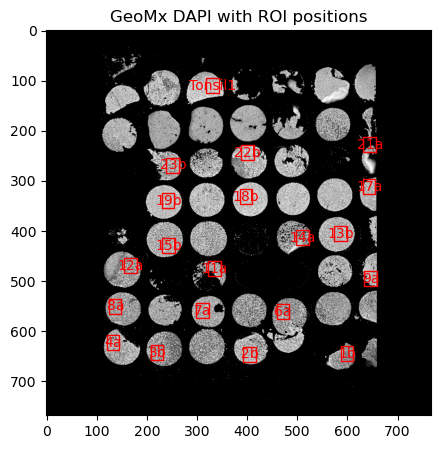

In [12]:
# Visualize GeoMx ROI positions on DAPI image
step = 64
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(np.log1p(geomx_dapi[::step, ::step]), cmap="gray")
ax_plot_core_positions(
    geomx_roi_positions,
    x_min="x_min_px",
    x_max="x_max_px",
    y_min="y_min_px",
    y_max="y_max_px",
    core_id="roi",
    step=step,
)
ax.set_title("GeoMx DAPI with ROI positions");

### 1-2. CODEX data

#### 1-2-1. CODEX DAPI image (slide)

In [13]:
# Load CODEX DAPI image
codex_dapi_f = input_dir / "codex_dapi.tiff"
codex_dapi = tifffile.imread(codex_dapi_f)
print(f"CODEX DAPI loaded: shape = {codex_dapi.shape}, dtype = {codex_dapi.dtype}")

CODEX DAPI loaded: shape = (34560, 34560), dtype = uint8


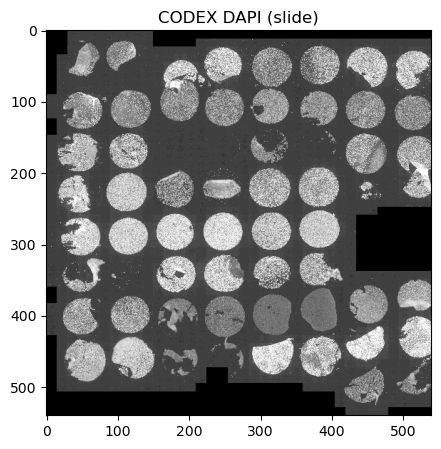

In [14]:
# Visualize CODEX DAPI image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(np.log1p(codex_dapi[::64, ::64]), cmap="gray")
ax.set_title("CODEX DAPI (slide)");

#### 1-2-2. CODEX segmentation mask

An array with a same shape of CODEX DAPI image. The value of each pixel represents cell label.

In [15]:
# Load CODEX segmentation mask
codex_seg_f = input_dir / "codex_segmentation_mask.tiff"
codex_seg = tifffile.imread(codex_seg_f)
print(
    f"CODEX segmentation mask loaded: shape = {codex_seg.shape}, dtype = {codex_seg.dtype}"
)

CODEX segmentation mask loaded: shape = (34560, 34560), dtype = uint64


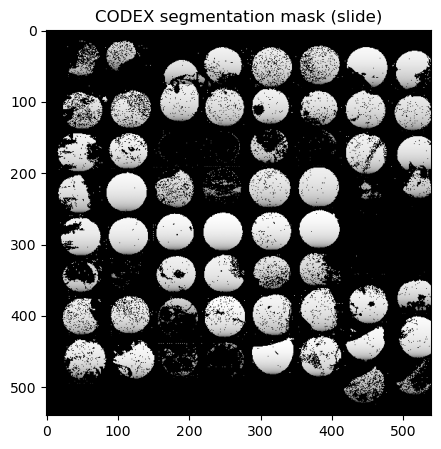

In [16]:
# Visualize segmentation mask
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(np.log1p(codex_seg[::64, ::64]), cmap="gray")
ax.set_title("CODEX segmentation mask (slide)");

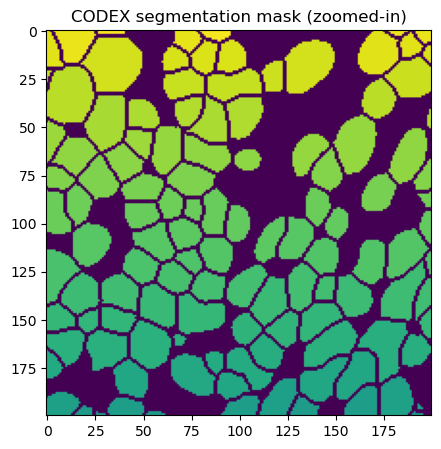

In [17]:
# Visualize segmentation mask (zoomed-in)
codex_seg_sm = codex_seg[3500:3700, 3500:3700].copy()
boundaries = find_boundaries(codex_seg_sm, mode="inner", connectivity=1, background=0)
codex_seg_sm[boundaries] = 0

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(codex_seg_sm)
ax.set_title("CODEX segmentation mask (zoomed-in)");

#### 1-2-3. CODEX core position

In [18]:
# Load CODEX core position
codex_core_positions_f = Path(input_dir / "codex_core_positions.csv")
codex_core_positions = pd.read_csv(codex_core_positions_f)
print(codex_core_positions.head())

  core     x1     x2    y1    y2
0  1.1   1850   5118   762  4921
1  1.2   5118   9241   848  4585
2  2.1   9241  13594  2469  4828
3  2.2  13594  17998  1315  5031
4  3.1  17998  22498  1357  5175


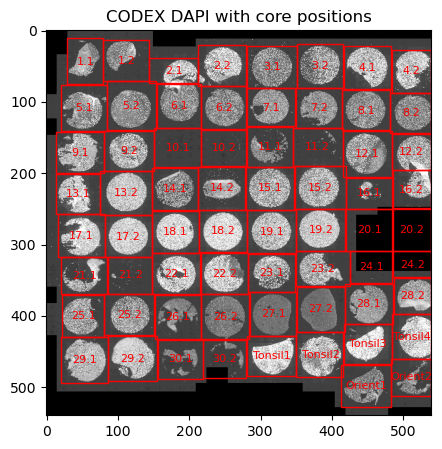

In [19]:
# Visualize core positions on images
step = 64
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(np.log1p(codex_dapi[::step, ::step]), cmap="gray")
ax_plot_core_positions(codex_core_positions, step=step, text_size=8)
ax.set_title("CODEX DAPI with core positions");

#### 1-2-4. CODEX annotation

In [20]:
codex_annotation_f = input_dir / "codex_annotation.csv"
codex_annotation = pd.read_csv(codex_annotation_f, converters={"core": str})
print(codex_annotation.head())

   cell_label annotation  core
0          32     CD8mem  11.1
1         582     CD8mem  11.1
2        1376     CD8mem  11.1
3        1866     CD8mem  11.1
4        2150     CD8mem  11.1


## 2. Image Registration 

(take core 2.2 as example)

### 2-1. Feature Detection

In [21]:
core = "2.2"

output_dir_core = output_dir / "registration" / core
output_dir_core.mkdir(parents=True, exist_ok=True)

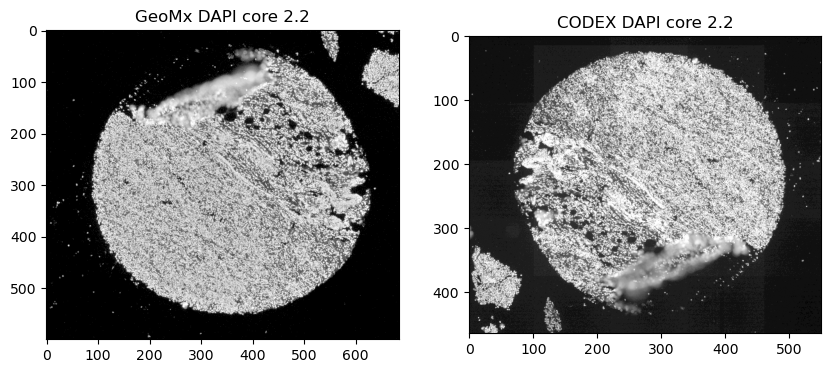

In [22]:
# GeoMx core DAPI
geomx_core_position = geomx_core_positions[geomx_core_positions["core"] == core].iloc[0]
geomx_dapi_core = geomx_dapi[
    geomx_core_position["y1"] : geomx_core_position["y2"],
    geomx_core_position["x1"] : geomx_core_position["x2"],
]

# CODEX core DAPI
codex_core_position = codex_core_positions[codex_core_positions["core"] == core].iloc[0]
codex_dapi_core = codex_dapi[
    codex_core_position["y1"] : codex_core_position["y2"],
    codex_core_position["x1"] : codex_core_position["x2"],
]

# CODEX core segmentation mask
codex_seg_core = codex_seg[
    codex_core_position["y1"] : codex_core_position["y2"],
    codex_core_position["x1"] : codex_core_position["x2"],
]

# Visualize core DAPI images
step = 8
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.log1p(geomx_dapi_core[::step, ::step]), cmap="gray")
axes[0].set_title(f"GeoMx DAPI core {core}")
axes[1].imshow(np.log1p(codex_dapi_core[::step, ::step]), cmap="gray")
axes[1].set_title(f"CODEX DAPI core {core}");

In [23]:
# SIFT registration (CODEX to GeoMx)

# Initialize SIFT detector
sift = cv2.SIFT_create(nfeatures=10000)

# Find keypoints and descriptors
kp1, des1 = sift.detectAndCompute(codex_dapi_core, None)
kp2, des2 = sift.detectAndCompute(geomx_dapi_core, None)

# Initialize matcher
matcher = cv2.BFMatcher()

# Match descriptors
matches = matcher.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good_matches.append(m)

# Extract matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Compute affine transformation
affine_matrix = cv2.estimateAffinePartial2D(src_pts, dst_pts)[0]
affine_matrix_inverse = np.linalg.pinv(affine_matrix)

print("Finished feature detection and feature matching.")

Finished feature detection and feature matching.


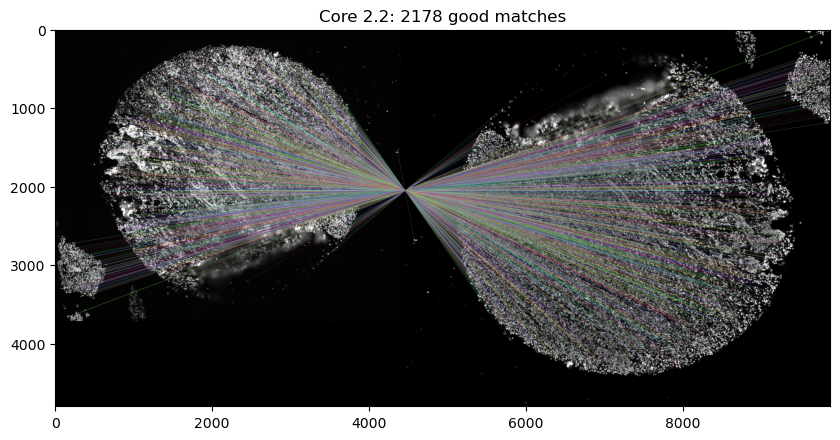

In [24]:
# Visualize matches
match_img = cv2.drawMatches(
    codex_dapi_core,
    kp1,
    geomx_dapi_core,
    kp2,
    good_matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(match_img)
ax.set_title(f"Core {core}: {len(good_matches)} good matches");

In [25]:
# Save the affine transformation matrix
np.savetxt(output_dir_core / "affine_matrix.txt", affine_matrix)
np.savetxt(output_dir_core / "inverse_affine_matrix.txt", affine_matrix_inverse)
print("Finished writing transformation matrices.")

Finished writing transformation matrices.


### 2-2. Warping CODEX coordinates to GeoMx coordinates

To warp segmentation mask and annotation generated from CODEX to GeoMx coordinates. So that we can generate cell-type specific mask for GeoMx.

In [26]:
src_height, src_width = codex_dapi_core.shape
dst_height, dst_width = geomx_dapi_core.shape

# Convert fusion to geomx coordinate system with affine matrix
codex_dapi_core_warp = cv2.warpAffine(
    codex_dapi_core,
    affine_matrix,
    (geomx_dapi_core.shape[1], geomx_dapi_core.shape[0]),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=0,
)

codex_seg_core_warp = cv2.warpAffine(
    codex_seg_core.astype(np.float64),
    affine_matrix,
    (geomx_dapi_core.shape[1], geomx_dapi_core.shape[0]),
    flags=cv2.INTER_NEAREST,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=0,
).astype(codex_seg_core.dtype)

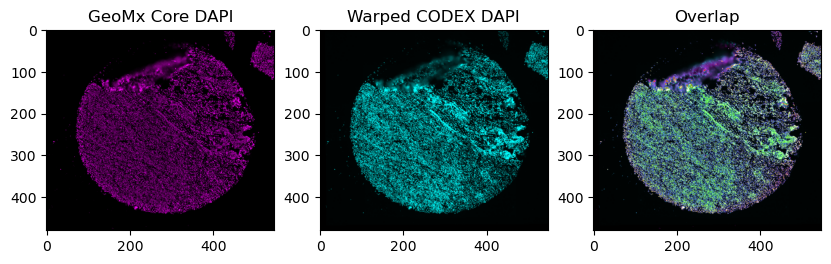

In [27]:
# Visualize warped CODEX DAPI
step = 10
geomx_color = (255, 0, 255)  # Magenta
codex_color = (0, 255, 255)  # Cyan

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Plot GeoMx DAPI
ax = axes[0]
rgb_geomx_core = (geomx_dapi_core - np.min(geomx_dapi_core)) / (
    np.max(geomx_dapi_core) - np.min(geomx_dapi_core)
)
rgb_geomx_core = np.stack([rgb_geomx_core] * 3, axis=-1)
rgb_geomx_core = (rgb_geomx_core * geomx_color).astype(np.uint8)
ax.imshow(rgb_geomx_core[::step, ::step])
ax.set_title("GeoMx Core DAPI")

# Plot warped CODEX DAPI
ax = axes[1]
rgb_codex_core_warp = (codex_dapi_core_warp - np.min(codex_dapi_core_warp)) / (
    np.max(codex_dapi_core_warp) - np.min(codex_dapi_core_warp)
)
rgb_codex_core_warp = np.stack([rgb_codex_core_warp] * 3, axis=-1)
rgb_codex_core_warp = (rgb_codex_core_warp * codex_color).astype(np.uint8)
ax.imshow(rgb_codex_core_warp[::step, ::step])
ax.set_title("Warped CODEX DAPI")

# Plot overlap
ax = axes[2]
rgb_overlap = rgb_geomx_core + rgb_codex_core_warp
rgb_overlap = np.clip(rgb_overlap, 0, 255)
ax.imshow(rgb_overlap[::step, ::step])
ax.set_title("Overlap")
plt.show()


In [28]:
# Save aligned CODEX DAPI and segmentation mask
output_f = output_dir_core / "warped_codex_dapi.tiff"
tifffile.imwrite(output_f, codex_dapi_core_warp)

output_f = output_dir_core / "warped_codex_segmentation_mask.tiff"
tifffile.imwrite(output_f, codex_seg_core_warp)

## 3. ROI segmentation and annotation mask

In [29]:
# Search ROIs within the core
geomx_core_position = geomx_core_positions[geomx_core_positions["core"] == core].iloc[0]
geomx_roi_positions_core = geomx_roi_positions[
    (geomx_roi_positions["x_min_px"] >= geomx_core_position["x1"])
    & (geomx_roi_positions["x_max_px"] <= geomx_core_position["x2"])
    & (geomx_roi_positions["y_min_px"] >= geomx_core_position["y1"])
    & (geomx_roi_positions["y_max_px"] <= geomx_core_position["y2"])
]
print(geomx_roi_positions_core.head())

  roi  x_cent_um  y_cent_um     x_cent_px     y_cent_px  x_min_px  x_max_px  \
9  2b    10330.6    16493.0  25967.371818  41390.076433     25138     26797   

   y_min_px  y_max_px  
9     40405     42375  


In [30]:
# Extract ROI segmentation mask
roi = "2b"
geomx_roi_position = geomx_roi_positions_core[
    geomx_roi_positions_core["roi"] == roi
].iloc[0]

# shift relative to core
x_shift = geomx_core_position["x1"]
y_shift = geomx_core_position["y1"]

x_min = int(geomx_roi_position["x_min_px"] - x_shift)
x_max = int(geomx_roi_position["x_max_px"] - x_shift)
y_min = int(geomx_roi_position["y_min_px"] - y_shift)
y_max = int(geomx_roi_position["y_max_px"] - y_shift)
codex_seg_roi_warp = codex_seg_core_warp[y_min:y_max, x_min:x_max]

In [31]:
# Define the color and output name of each cell type you want in the GeoMX segment file name
celltype_color = {
    "CD8mem": "1f77b4",
    "Other": "ff7f0e",
    "Tumor": "2ca02c",
    "Neutrophil": "d62728",
    "Endothelial": "9467bd",
    "Treg": "8c564b",
    "CD4naive": "e377c2",
    "DC": "7f7f7f",
    "CD8naive": "bcbd22",
    "CD4mem": "17becf",
    "M2": "aec7e8",
    "M1": "ffbb78",
    "Other Tumor": "98df8a",
    "Tumor BCL2": "ff9896",
    "Tumor Myc": "c5b0d5",
    "Tumor BCL6": "c49c94",
    "B cell": "f7b6d2",
}

celltype_outname = {
    "CD8mem": "CD8mem",
    "Other": "Other",
    "Tumor": "Tumor",
    "Neutrophil": "Neutrophil",
    "Endothelial": "Endothelial",
    "Treg": "Treg",
    "CD4naive": "CD4naive",
    "DC": "DC",
    "CD8naive": "CD8naive",
    "CD4mem": "CD4mem",
    "M2": "M2",
    "M1": "M1",
    "Other Tumor": "TumorOther",
    "Tumor BCL2": "TumorBCL2",
    "Tumor Myc": "TumorMyc",
    "Tumor BCL6": "TumorBCL6",
    "B cell": "BCell",
}

In [32]:
# Annotation for the ROI
codex_annotation_core = codex_annotation[codex_annotation["core"] == core]
annotation_dict = codex_annotation_core.set_index("cell_label")["annotation"].to_dict()

codex_annotation_roi = pd.DataFrame(
    np.unique(codex_seg_roi_warp), columns=["cell_label"]
)
codex_annotation_roi["annotation"] = codex_annotation_roi["cell_label"].map(
    annotation_dict
)
codex_annotation_roi = codex_annotation_roi[codex_annotation_roi["cell_label"] != 0]
codex_annotation_roi["color"] = codex_annotation_roi["annotation"].map(
    lambda x: f"#{celltype_color[x]}"
)
print(codex_annotation_roi.head())

   cell_label   annotation    color
1        7319  Endothelial  #9467bd
2        7349       CD4mem  #17becf
3        7366  Endothelial  #9467bd
4        7376  Endothelial  #9467bd
5        7377  Endothelial  #9467bd


In [33]:
# Celltype mask generation order
celltype_count = codex_annotation_roi["annotation"].value_counts().sort_values()
celltype_order = celltype_count[celltype_count > 20].index.tolist()

# Put "Other" at the end of the list
if "Other" in celltype_order:
    celltype_order = [ct for ct in celltype_order if ct != "Other"]
    celltype_order.append("Other")
print(f"Extraction order after excluding cells < 20: {celltype_order}")

Extraction order after excluding cells < 20: ['Tumor Myc', 'Other Tumor', 'DC', 'CD8naive', 'Treg', 'Tumor BCL2', 'M2', 'CD4naive', 'M1', 'Tumor BCL6', 'CD8mem', 'Endothelial', 'CD4mem', 'Other']


In [34]:
# Celltype mask generation
for i, celltype in tqdm(
    enumerate(celltype_order),
    total=len(celltype_order),
    desc="Generating celltype masks",
    bar_format=TQDM_FORMAT,
):
    celltype_cell_labels = codex_annotation_roi[
        codex_annotation_roi["annotation"] == celltype
    ]["cell_label"].values

    binary_mask = (
        np.isin(codex_seg_roi_warp, celltype_cell_labels).astype(np.uint8) * 255
    )

    output_dir_roi = output_dir / "geomx_binary_mask" / roi
    output_dir_roi.mkdir(parents=True, exist_ok=True)

    output_name = (
        f"{roi}_{celltype_outname[celltype]}_{i + 1}_{celltype_color[celltype]}.tiff"
    )
    tifffile.imwrite(output_dir_roi / output_name, binary_mask)

Generating celltype masks: 100%|██████████████████████████████| 14/14 [00:00<00:00, 30.67it/s]


In [35]:
!tree $output_dir

/mnt/nfs/storage/wenruiwu_temp/indepth/tutorial/output
├── geomx_binary_mask
│   └── 2b
│       ├── 2b_CD4mem_13_17becf.tiff
│       ├── 2b_CD4naive_8_e377c2.tiff
│       ├── 2b_CD8mem_11_1f77b4.tiff
│       ├── 2b_CD8naive_4_bcbd22.tiff
│       ├── 2b_DC_3_7f7f7f.tiff
│       ├── 2b_Endothelial_12_9467bd.tiff
│       ├── 2b_M1_9_ffbb78.tiff
│       ├── 2b_M2_7_aec7e8.tiff
│       ├── 2b_Other_14_ff7f0e.tiff
│       ├── 2b_Treg_5_8c564b.tiff
│       ├── 2b_TumorBCL2_6_ff9896.tiff
│       ├── 2b_TumorBCL6_10_c49c94.tiff
│       ├── 2b_TumorMyc_1_c5b0d5.tiff
│       └── 2b_TumorOther_2_98df8a.tiff
└── registration
    └── 2.2
        ├── affine_matrix.txt
        ├── inverse_affine_matrix.txt
        ├── sift_matches.png
        ├── warped_codex_dapi.tiff
        └── warped_codex_segmentation_mask.tiff

4 directories, 19 files


## 4. Visualization

In [36]:
# GeoMx ROI DAPI
geomx_dapi_roi = geomx_dapi_core[y_min:y_max, x_min:x_max]

# GeoMx ROI DAPI with warped CODEX segmentation boundary
rgb_dapi_roi = np.stack([uint16_to_uint8(geomx_dapi_roi)] * 3, axis=-1)
boundaries = find_boundaries(codex_seg_roi_warp, mode="inner", connectivity=1)
rgb_dapi_roi[boundaries] = (0, 255, 255)

# GeoMx ROI with warped CODEX annotation
rgb_annotation_roi, _ = segmentation_mask_to_phenotype_map(
    codex_seg_roi_warp, codex_annotation_roi
)

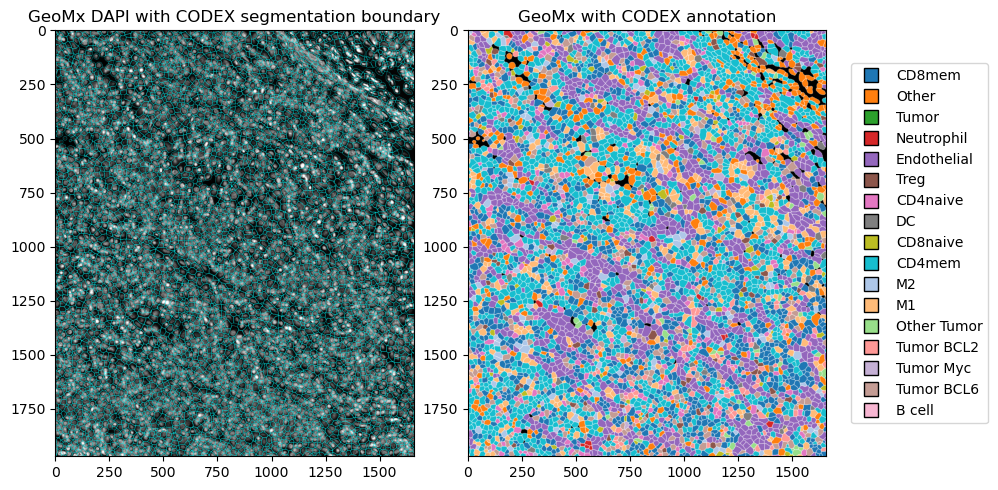

In [37]:
# Visualize ROI
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(rgb_dapi_roi)
axes[0].set_title("GeoMx DAPI with CODEX segmentation boundary")
axes[1].imshow(rgb_annotation_roi)
ax_plot_legend({k: f"#{v}" for k, v in celltype_color.items()})
axes[1].set_title("GeoMx with CODEX annotation")
fig.tight_layout();

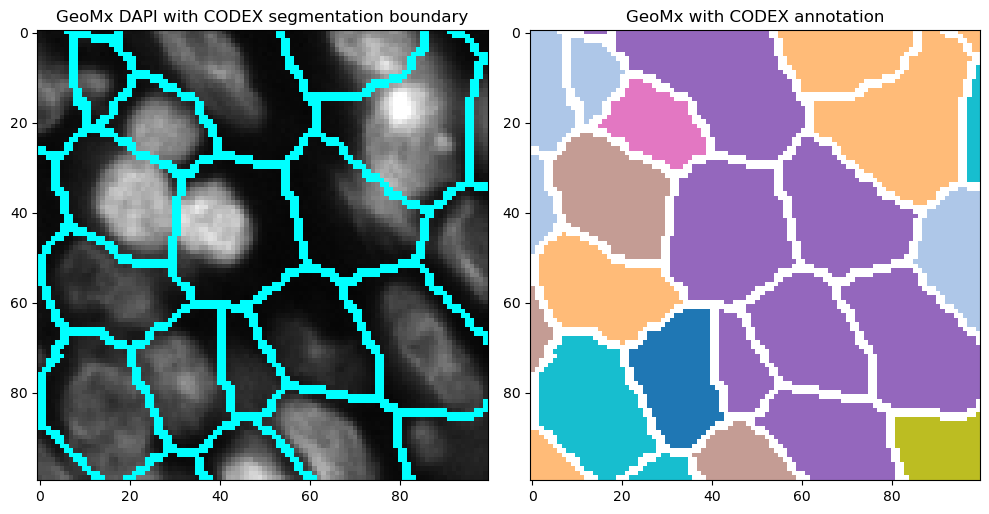

In [38]:
# Visualize ROI (zoomed-in)
x_0, y_0 = 0, 0
step = 100

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(rgb_dapi_roi[y_0 : y_0 + step, x_0 : x_0 + step])
axes[0].set_title("GeoMx DAPI with CODEX segmentation boundary")
axes[1].imshow(rgb_annotation_roi[y_0 : y_0 + step, x_0 : x_0 + step])
axes[1].set_title("GeoMx with CODEX annotation")
fig.tight_layout();